# Convex Optimization - Homework 3
Done by: NAIM Mouna

Email: mouna.naim@ens-paris-saclay.fr

# 1. Dual Problem of LASSO

In order to derive the dual problem of LASSO, we introduce a dummy variable \( u = Xw - y \) to incorporate an equality constraint. The LASSO problem is reformulated as:
$$
\min_{w \in \mathbb{R}^d, u \in \mathbb{R}^n} \frac{1}{2}\|u\|_2^2 + \lambda \|w\|_1 \quad \text{subject to } u = Xw - y.
$$

The Lagrangian of this problem is given by:
$$
\mathcal{L}(w, u, \nu) = \frac{1}{2}\|u\|_2^2 + \lambda \|w\|_1 + \nu^T(Xw - y - u),
$$
where \(\nu \in \mathbb{R}^n\) is the Lagrange multiplier.

We decompose \(\mathcal{L}(w, u, \nu)\) into two components:
$$
\mathcal{L}(w, u, \nu) = M(u) + N(w) - \nu^T y,
$$
where:
$$
M(u) = \frac{1}{2}\|u\|_2^2 - \nu^T u, \quad N(w) = \lambda \|w\|_1 + \nu^T Xw.
$$

### Minimizing with respect to \(u\)
To find \(M(u)\), we solve:
$$
\nabla_u M(u) = u - \nu = 0 \quad \implies u = \nu.
$$
Substituting \(u = \nu\), we find:
$$
M(u) = -\frac{1}{2}\|\nu\|_2^2.
$$

### Minimizing with respect to \(w\)
Using the conjugate function of the \(\ell_1\)-norm, we rewrite \(N(w)\) as:
$$
N(w) = \inf_w \left\{\lambda \|w\|_1 + w^T(X^T\nu)\right\}.
$$

$$
= -\lambda \sup_w \left[ \left( \frac{X^T \nu}{\lambda} \right)^T w - \|w\|_1 \right]
$$

$$
= -\lambda f^{*}\left(-\frac{X^T \nu}{\lambda}\right)
$$

The conjugate of \(\|w\|_1\) implies that:
$$
N(w) =
\begin{cases}
0, & \text{if } \|X^T\nu\|_\infty \leq \lambda, \\
-\infty, & \text{otherwise}.
\end{cases}
$$

Combining the results, the dual problem of LASSO is:
$$
\max_{\nu \in \mathbb{R}^n} \; -\frac{1}{2}\|\nu\|_2^2 - \nu^T y \quad \text{s.t. } \|X^T \nu\|_\infty \leq \lambda.
$$

This can be reformulated as a quadratic programming (QP) problem:
$$
\min_{\nu \in \mathbb{R}^n} \; \frac{1}{2}\|\nu\|_2^2 + y^T \nu \quad \text{s.t. } \|X^T \nu\|_\infty \leq \lambda.
$$

The QP formulation is equivalent to:
$$
\min_{\nu \in \mathbb{R}^n} \; \frac{1}{2}\nu^T\nu + y^T \nu, \quad \text{s.t. } A\nu \preceq b,
$$
where:
$$
A = 
\begin{pmatrix}
X^T \\
-X^T 
\end{pmatrix} \in R^{2d \times n}, 
\quad
b =
\begin{pmatrix}
\lambda \\
\vdots \\
\lambda 
\end{pmatrix} \in R^{2\times d}
$$


# 2. Implementation of the barrier method to solve QP

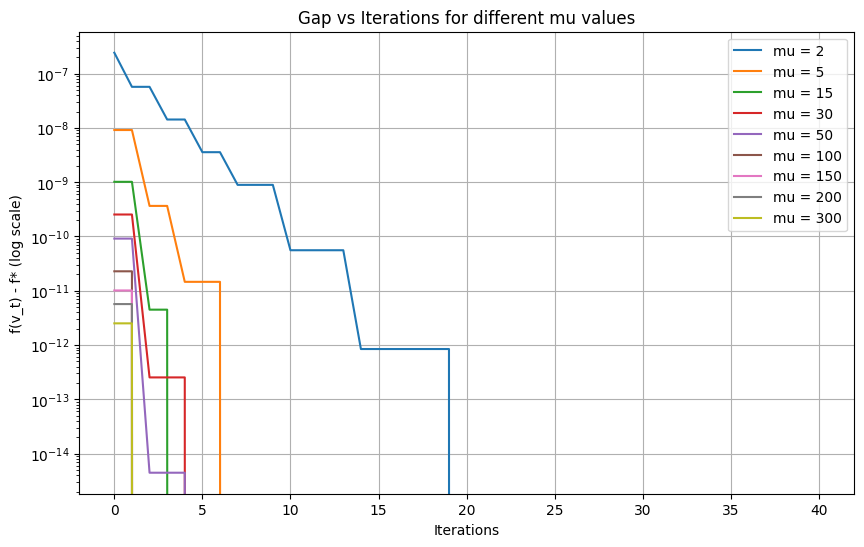

Total number of iterations for each mu: {2: 41, 5: 20, 15: 13, 30: 11, 50: 10, 100: 9, 150: 9, 200: 9, 300: 8}


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Quadratic objective function
def f(v, Q, p):
    return 0.5 * v.T @ Q @ v + p.T @ v

# Function to generate random matrices and data
def generate_data(n, d, lamb):
    np.random.seed(4)  # Set seed for reproducibility
    X = np.random.randn(n, d)  # Generate random feature matrix
    y = np.random.randn(n)  # Generate random target vector
    Q = X.T @ X  # Compute Q matrix
    p = -X.T @ y  # Compute p vector
    A = np.vstack([np.eye(d), -np.eye(d)])  # Construct constraint matrix
    b = lamb * np.ones(2 * d)  # Constraint bounds
    return Q, p, A, b

# Newton-based centering step
def centering_step(Q, p, A, b, t, v0, eps):
    v = v0
    iterates = [v]  # Store the sequence of iterates
    while True:
        # Compute gradient
        grad = t * (Q @ v + p) + A.T @ (1 / (b - A @ v))
        
        # Compute Hessian
        hessian = t * Q + A.T @ np.diag(1 / (b - A @ v) ** 2) @ A
        
        # Compute Newton step
        newton_step = np.linalg.solve(hessian, -grad)
        
        # Check stopping condition
        if 0.5 * newton_step.T @ hessian @ newton_step < eps:
            break
        
        # Backtracking line search
        alpha = 0.1  # Step size scaling factor
        beta = 0.7  # Reduction factor
        step_size = 1  # Initialize step size
        while np.any(b - A @ (v + step_size * newton_step) <= 0):  # Ensure feasibility
            step_size *= beta  # Reduce step size
        v += step_size * newton_step  # Update iterate
        iterates.append(v)
    
    return np.array(iterates), len(iterates)

# Test barrier method for different values of mu
def test_barrier_method():
    n, d = 100, 10  # Number of samples and dimensions
    lamb = 10  # Regularization parameter
    Q, p, A, b = generate_data(n, d, lamb)
    v0 = np.random.rand(d)  # Initial feasible point
    eps = 1e-8  # Tolerance for convergence
    
    # Approximate optimal value using a reference solution
    from scipy.optimize import minimize
    res = minimize(lambda v: f(v, Q, p), v0, constraints={'type': 'ineq', 'fun': lambda v: b - A @ v})
    f_star = res.fun  # Approximate optimal objective value

    # Different values of mu to test
    mu_values = [2, 5, 15, 30, 50, 100, 150, 200, 300]
    gap_results = {}
    iterations_results = {}

    for mu in mu_values:
        def barr_method_with_mu(Q, p, A, b, v0, eps, mu):
            t = 1  # Initial scaling parameter
            iterates = []  # List to store iterates
            total_iterations = 0  # Total iterations count

            while True:
                v_seq, num_iter = centering_step(Q, p, A, b, t, v0, eps)
                v0 = v_seq[-1]  # Update initial point
                iterates.extend(v_seq)  # Append sequence of iterates
                total_iterations += num_iter

                gap = len(b) / t  # Duality gap
                if gap < eps:  # Check convergence
                    break
                t *= mu  # Increase barrier parameter

            return np.array(iterates), total_iterations

        iterates, total_iterations = barr_method_with_mu(Q, p, A, b, v0, eps, mu)
        final_v = iterates[-1]  # Final iterate
        gaps = [f(v, Q, p) - f_star for v in iterates]  # Compute gaps for each iterate

        gap_results[mu] = gaps
        iterations_results[mu] = total_iterations

    # Plot the results
    plt.figure(figsize=(10, 6))
    for mu in mu_values:
        plt.semilogy(gap_results[mu], label=f"mu = {mu}")  # Log scale for gaps
    plt.xlabel("Iterations")
    plt.ylabel("f(v_t) - f* (log scale)")
    plt.title("Gap vs Iterations for different mu values")
    plt.legend()
    plt.grid()
    plt.show()

    return iterations_results

# Run the test
results = test_barrier_method()
print("Total number of iterations for each mu:", results)
